In [5]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain.messages import RemoveMessage, HumanMessage
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [4]:
class ChatState(MessagesState):
    summary: str

In [7]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = llm.invoke(messages)
    return {"messages": [response]}

In [8]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [HumanMessage(content=prompt)]

    response = llm.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [9]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [10]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: END,
    }
)

builder.add_edge("summarize", END)

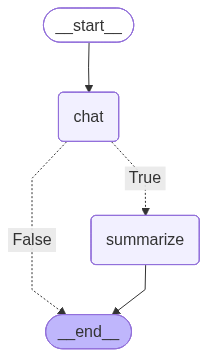

In [11]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph

In [12]:
config = {"configurable": {"thread_id": "t1"}}

In [13]:
def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [14]:
# gives the current version of the state
def show_state():
    
    snap = graph.get_state(config)
    vals = snap.values
    
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [15]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='f21aa413-7090-4e52-989c-fd174080b052')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, also known as quantum mechanics, is a branch of physics that st


In [16]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='f21aa413-7090-4e52-989c-fd174080b052'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at the smallest scales. It is a fundamental theory that describes the nature of reality at the atomic and subatomic level.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled" in such a way that the state of one object is d

In [17]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='f21aa413-7090-4e52-989c-fd174080b052'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at the smallest scales. It is a fundamental theory that describes the nature of reality at the atomic and subatomic level.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled" in such a way that the state of one object is d

In [18]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='f21aa413-7090-4e52-989c-fd174080b052'), AIMessage(content='Quantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at the smallest scales. It is a fundamental theory that describes the nature of reality at the atomic and subatomic level.\n\n**Key Principles of Quantum Physics:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, such as its position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled" in such a way that the state of one object is d